In [1]:
#%pip install ctgan

In [ ]:
#%pip install ctgan umap-learn

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.semi_supervised import LabelPropagation
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans

import xgboost as xgb
import shap
import umap.umap_ as umap

# For reproducibility
RNG = np.random.default_rng(42)
sns.set(style="whitegrid")
%matplotlib inline

c:\Users\MOHAMMAD ADNAN\Desktop\Pharmedic_Clinical_Algo\test1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1.1 Load raw TSV and assign columns
df = pd.read_csv(
    "meddra_all_se.tsv", sep="\t", header=None,
    names=["drug_id","umls_id","side_effect_name",
           "frequency","placebo","meddra_code"]
)

# 1.2 Save CSV for easier reloading
df.to_csv("meddra_all_se.csv", index=False)

# 1.3 Load CSV and pivot to binary Drug×SE matrix
df = pd.read_csv("meddra_all_se.csv")
binary_df = pd.crosstab(df.drug_id, df.side_effect_name).clip(0,1)

print("Binary matrix shape:", binary_df.shape)  # expect (1430, ~5868)


Binary matrix shape: (1430, 5868)


In [3]:
# 2.1 Define target ADR label
target = "C0000737"  # Abdominal pain
y = binary_df[target].values

# 2.2 Mask ~95% of labels
mask = RNG.random(len(y)) > 0.95
y_semi = np.where(mask, y, -1)

# 2.3 Fit LabelPropagation on raw high-dimensional data
lp = LabelPropagation(kernel="knn", n_neighbors=5)
lp.fit(binary_df.values, y_semi)
y_pred = lp.transduction_

# 2.4 Print classification report
print("Baseline LP (raw features):")
print(classification_report(y, y_pred))


Baseline LP (raw features):
              precision    recall  f1-score   support

           0       0.48      1.00      0.64       655
           1       1.00      0.07      0.13       775

    accuracy                           0.50      1430
   macro avg       0.74      0.53      0.39      1430
weighted avg       0.76      0.50      0.36      1430



In [4]:
# 3.1 Reduce dimensionality with PCA
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(binary_df.values)

# 3.2 Fit LabelPropagation on PCA-transformed data
lp2 = LabelPropagation(kernel="knn", n_neighbors=5)
lp2.fit(X_pca, y_semi)
y_pred2 = lp2.transduction_

# 3.3 Print classification report
print("LP after PCA:")
print(classification_report(y, y_pred2))


LP after PCA:
              precision    recall  f1-score   support

           0       0.52      0.99      0.68       655
           1       0.96      0.23      0.38       775

    accuracy                           0.58      1430
   macro avg       0.74      0.61      0.53      1430
weighted avg       0.76      0.58      0.52      1430



In [5]:
# 4.1 Sample 300 random drugs and select top 100 SEs
subset = binary_df.sample(181, random_state=42)
top100 = subset.sum(axis=0).nlargest(100).index
X_ct = subset[top100].reset_index(drop=True)
print("CTGAN input shape:", X_ct.shape)  # (300,100)

CTGAN input shape: (181, 100)


In [6]:
from ctgan import CTGAN
# 4.2 Train CTGAN with pac=1 for speed
gan = CTGAN(epochs=10, batch_size=32, pac=1)
gan.fit(X_ct)

# 4.3 Generate 200 synthetic profiles
syn = gan.sample(200)
print("Synthetic shape:", syn.shape)  # (200,100)

Synthetic shape: (200, 100)


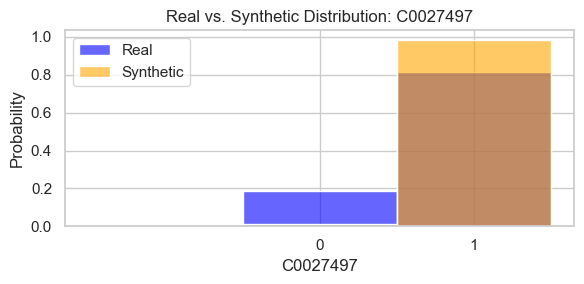

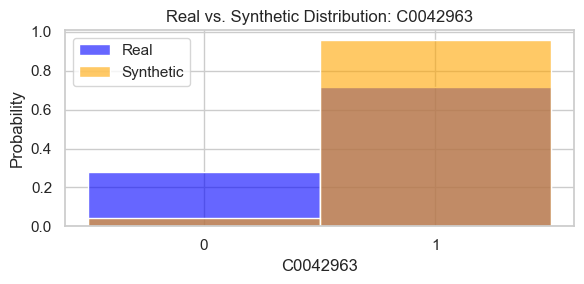

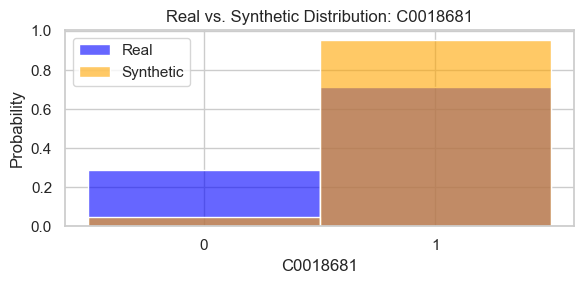

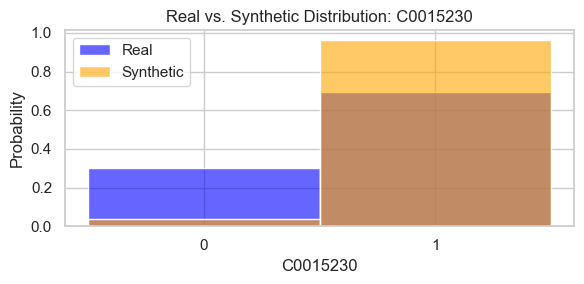

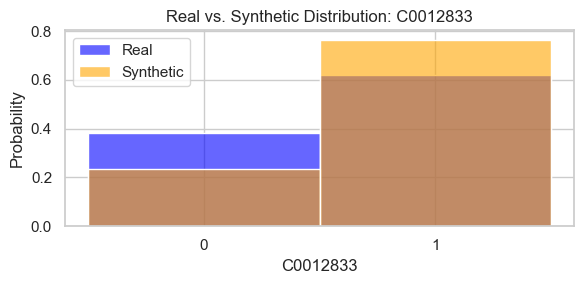

In [7]:
import seaborn as sns
from sklearn.decomposition import PCA

# 4.4.1 Loop through the first 5 top features
for feat in top100[:5]:
    plt.figure(figsize=(6,3))
    # real
    sns.histplot(
        X_ct[feat],
        stat='probability',
        discrete=True,
        color='blue',
        alpha=0.6,
        label='Real'
    )
    # synthetic
    sns.histplot(
        syn[feat],
        stat='probability',
        discrete=True,
        color='orange',
        alpha=0.6,
        label='Synthetic'
    )
    plt.xticks([0,1])
    plt.xlabel(feat)
    plt.ylabel('Probability')
    plt.title(f'Real vs. Synthetic Distribution: {feat}')
    plt.legend()
    plt.tight_layout()
    plt.show()




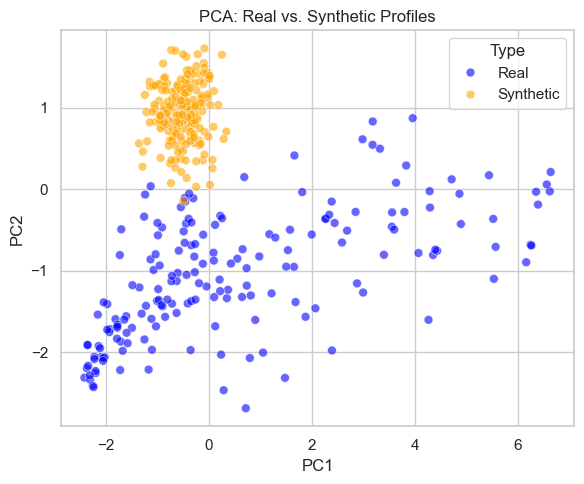

In [8]:


# 4.4.2 PCA scatter with seaborn
#  – Build a combined DataFrame with PC1, PC2, and a Type column
combined = pd.concat([X_ct, syn], ignore_index=True)
types = ['Real']*len(X_ct) + ['Synthetic']*len(syn)
pca2 = PCA(n_components=2, random_state=42)
proj = pca2.fit_transform(combined)

df_proj = pd.DataFrame(proj, columns=['PC1','PC2'])
df_proj['Type'] = types

plt.figure(figsize=(6,5))
sns.scatterplot(
    data=df_proj,
    x='PC1', y='PC2',
    hue='Type',
    palette=['blue','orange'],
    alpha=0.6,
    s=40
)
plt.title('PCA: Real vs. Synthetic Profiles')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.tight_layout()
plt.show()


In [9]:
# 5.1 Train on real subset only
y_ct = subset[target].values
model = xgb.XGBClassifier(
    use_label_encoder=False, eval_metric="logloss", random_state=42
)
model.fit(X_ct, y_ct)


c:\Users\MOHAMMAD ADNAN\Desktop\Pharmedic_Clinical_Algo\test1\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:12:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


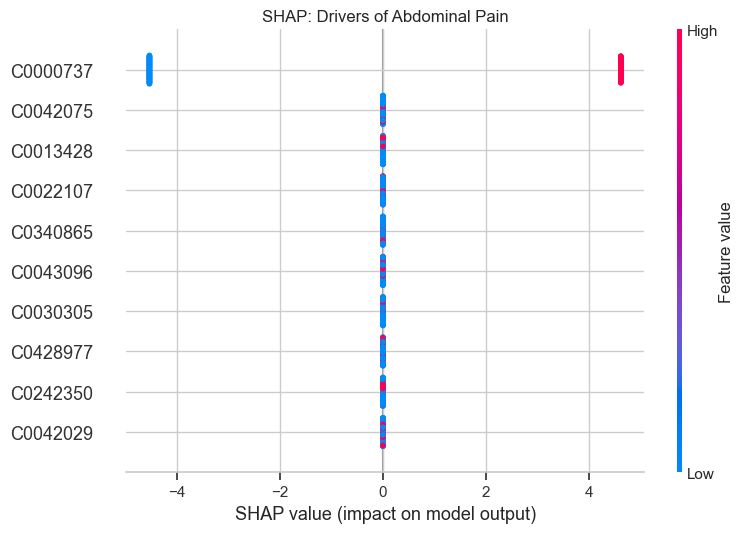

In [10]:
# 5.2 SHAP explainability on real data
explainer = shap.Explainer(model)
shap_vals = explainer(X_ct)

plt.figure(figsize=(6,4))
shap.summary_plot(shap_vals, X_ct, max_display=10, show=False)
plt.title("SHAP: Drivers of Abdominal Pain")
plt.tight_layout()
plt.show()


In [11]:
from sklearn.utils import shuffle
import xgboost as xgb
from sklearn.metrics import classification_report
from ctgan import CTGAN

# 5.3.1 Re-create evaluation set
subset = binary_df.sample(181, random_state=42)
top100 = subset.sum(axis=0).nlargest(100).index.tolist()
X_ct = subset[top100].reset_index(drop=True)
y_ct = subset[target].values
print(f"Eval set X_ct: {X_ct.shape}, y_ct: {y_ct.shape}")

# 5.3.2 Split into real pos/neg
X_pos_real = X_ct[y_ct == 1]
X_neg_real = X_ct[y_ct == 0]
print(f"Real pos: {X_pos_real.shape}, Real neg: {X_neg_real.shape}")

# 5.3.3 Balance both to the smaller class size
n_pos, n_neg = len(X_pos_real), len(X_neg_real)
n_min = min(n_pos, n_neg)
X_pos_bal = X_pos_real.sample(n=n_min, random_state=42)
X_neg_bal = X_neg_real.sample(n=n_min, random_state=42)
print(f"Balanced pos & neg to {n_min} each")

# 5.3.4 Train CTGAN on balanced positives & sample synthetic positives
gan_pos = CTGAN(epochs=10, batch_size=32, pac=1)
gan_pos.fit(X_pos_bal)
syn_pos = gan_pos.sample(n_min)
print(f"Synthetic pos: {syn_pos.shape}")

# 5.3.5 Build training set & labels
X_train = pd.concat([X_pos_bal, X_neg_bal, syn_pos], ignore_index=True)
y_train = np.concatenate([
    np.ones(n_min),    # real positives
    np.zeros(n_min),   # real negatives
    np.ones(n_min)     # synthetic positives
])
print(f"Train set X_train: {X_train.shape}, y_train: {y_train.shape}")

# 5.3.6 Shuffle, train XGB, and evaluate on real subset
X_train, y_train = shuffle(X_train, y_train, random_state=42)
model_aug = xgb.XGBClassifier(
    use_label_encoder=False, eval_metric="logloss", random_state=42
)
model_aug.fit(X_train, y_train)

y_pred_aug = model_aug.predict(X_ct)
print("XGB on Balanced + Augmented Data:")
print(classification_report(y_ct, y_pred_aug))

Eval set X_ct: (181, 100), y_ct: (181,)
Real pos: (88, 100), Real neg: (93, 100)
Balanced pos & neg to 88 each
Synthetic pos: (88, 100)
Train set X_train: (264, 100), y_train: (264,)
XGB on Balanced + Augmented Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        93
           1       1.00      1.00      1.00        88

    accuracy                           1.00       181
   macro avg       1.00      1.00      1.00       181
weighted avg       1.00      1.00      1.00       181



c:\Users\MOHAMMAD ADNAN\Desktop\Pharmedic_Clinical_Algo\test1\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:12:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


c:\Users\MOHAMMAD ADNAN\Desktop\Pharmedic_Clinical_Algo\test1\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


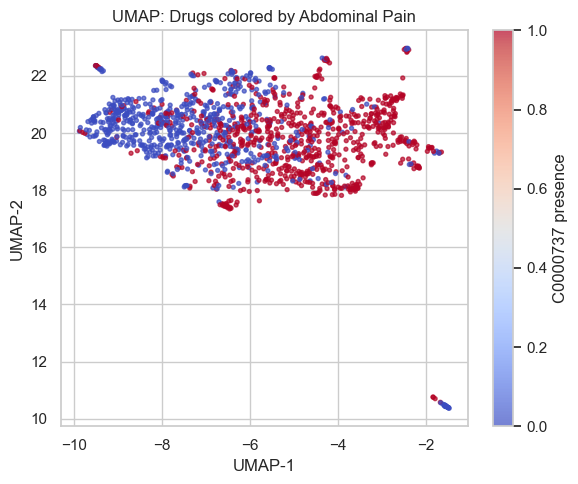

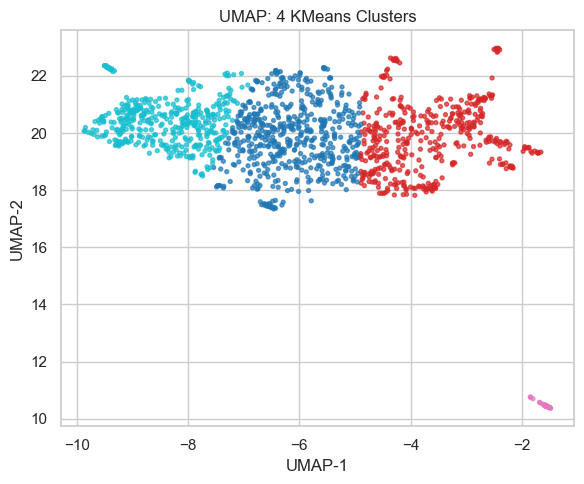

In [12]:
# 6.1 Compute 2D UMAP on the full binary matrix
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_emb = reducer.fit_transform(binary_df.values)

# 6.2 Color by abdominal-pain label
labels = binary_df[target].values
plt.figure(figsize=(6,5))
sc = plt.scatter(
    umap_emb[:,0], umap_emb[:,1],
    c=labels, cmap="coolwarm", s=8, alpha=0.7
)
plt.colorbar(sc, label="C0000737 presence")
plt.title("UMAP: Drugs colored by Abdominal Pain")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()

# 6.3 Run KMeans on that embedding
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=4, random_state=42).fit_predict(umap_emb)

plt.figure(figsize=(6,5))
plt.scatter(
    umap_emb[:,0], umap_emb[:,1],
    c=clusters, cmap="tab10", s=8, alpha=0.7
)
plt.title("UMAP: 4 KMeans Clusters")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()


In [14]:
# Step 1 & 2: Save the trained model
import joblib
import os

output_dir = 'intern_submissions/Fathima_Arfa'
os.makedirs(output_dir, exist_ok=True)

model_path = os.path.join(output_dir, 'adr_model_xgboost.joblib')
joblib.dump(model_aug, model_path)

print(f"Model saved to {model_path}")

Model saved to intern_submissions/Fathima_Arfa\adr_model_xgboost.joblib
